In [76]:
# imports and setup 
import pandas as pd
import scipy as sc
import numpy as np

import seaborn as sns

#%matplotlib notebook
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6) 

### Import data

In [122]:
df = pd.read_excel('DatasetEN.xlsx',index_col=0) #load data
print(df.shape)
df

(49028, 22)


,Status,Target date,Closed,Category,Subcategory,Call Type,Department,Call Date,Number of days current,Department.1,...,Time spent for Second Line,Date/time of creation,Date/time of change,Closure Date,Completion Date,Duration,Actual duration,Escalated,Major call,Entry
Line,,,,,,,,,,,,,,,,,,,,,
Second line call,Onterecht aangemaakt,2015-01-23 10:54:00,True,ICT SAP,SD (Verkoop),ICT Verstoring,NaN,2013-11-22 08:54:00,288,Klantenservice - Klantenservice-A - K&O,...,00:00:00,2013-11-22 08:54:34,2015-01-15 13:14:12,2015-01-15 13:14:00,2015-01-15 13:14:00,2 uur,1900-05-22 09:20:00,True,NaN,E-mail
Second line call,Afgehandeld,2015-09-18 11:52:00,True,ICT GIS,Smallworld NRM,ICT Verstoring,NaN,2014-06-04 11:52:00,322,Aanleg Leidingen - Aansluitleidingen - K&O,...,00:00:00,2014-06-04 11:52:15,2015-09-10 12:52:18,2015-09-10 12:52:00,2015-09-10 12:52:00,5 dagen,1900-06-08 09:30:00,True,NaN,E-mail
Second line call,Afgehandeld,2016-12-30 18:00:00,True,ICT GIS,Arcgis,ICT Verstoring,NaN,2014-07-21 15:15:00,183,NaN,...,00:00:00,2014-07-21 15:21:58,2015-04-08 07:57:11,2015-04-08 07:57:00,2015-04-08 07:57:00,5 dagen,1900-03-31 01:12:00,True,NaN,Telefonisch
Second line call,Afgehandeld,2015-07-17 15:45:00,True,ICT Infra,Netwerkverbinding,ICT Verstoring,NaN,2014-10-09 15:45:00,169,Productie - Centraal - K&O,...,00:00:00,2014-10-09 15:45:51,2015-06-16 14:28:58,2015-06-16 14:28:00,2015-06-16 14:28:00,5 dagen,1900-03-24 07:13:00,True,NaN,E-mail
Second line call,Afgehandeld,2015-02-27 10:42:00,True,ICT Overige applicaties,Kijk op water,ICT Vraag,NaN,2014-10-20 10:42:00,75,Onderhoud & Inspectie - Inspectie & Kwal. - K&O,...,00:00:00,2014-10-20 10:42:31,2015-02-05 09:10:00,2015-02-05 09:09:00,2015-02-05 09:09:00,5 dagen,1900-02-06 06:57:00,True,NaN,E-mail
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
First line call,Omgezet naar wijziging,2021-03-15 07:58:00,True,ICT GIS,Smallworld NRM,ICT Service Request,K&O - Aanleg leidingen - HAL,2021-03-12 15:58:00,0,Aanleg leidingen - K&O,...,00:00:00,2021-03-12 15:58:11,2021-03-12 16:24:37,2021-03-12 16:24:00,2021-03-12 16:24:00,4 uur,00:26:00,False,NaN,E-mail
First line call,Onterecht aangemaakt,2021-03-15 11:00:00,True,-,-,ICT Vraag,BO - ICT - ICT Service & Infra,2021-03-13 10:32:00,0,ICT - ICT Services & Infra - BO,...,00:00:00,2021-03-13 10:32:51,2021-03-13 14:13:56,2021-03-13 14:13:00,2021-03-13 14:13:00,4 uur,00:00:00,False,NaN,E-mail
First line call,Onterecht aangemaakt,2021-03-15 11:00:00,True,-,-,ICT Vraag,BO - ICT - ICT Service & Infra,2021-03-13 12:22:00,0,ICT - ICT Services & Infra - BO,...,00:00:00,2021-03-13 12:22:56,2021-03-13 14:14:02,2021-03-13 14:14:00,2021-03-13 14:14:00,4 uur,00:00:00,False,NaN,E-mail


In [123]:
df.keys()

Index(['Status', 'Target date', 'Closed', 'Category', 'Subcategory',
       'Call Type', 'Department', 'Call Date', 'Number of days current',
       'Department.1', 'Operator Group', 'Time spent for First line',
       'Time spent for Second Line', 'Date/time of creation',
       'Date/time of change', 'Closure Date', 'Completion Date', 'Duration',
       'Actual duration', 'Escalated', 'Major call', 'Entry'],
      dtype='object')

In [124]:
df.shape

(49028, 22)

## EDA

### Filter important columns

In [126]:
df = df[['Status', 'Target date','Category','Subcategory','Call Type','Department.1','Operator Group','Date/time of creation','Closure Date','Duration','Entry']]

In [127]:
df.head()

,Status,Target date,Category,Subcategory,Call Type,Department.1,Operator Group,Date/time of creation,Closure Date,Duration,Entry
Line,,,,,,,,,,,
Second line call,Onterecht aangemaakt,2015-01-23 10:54:00,ICT SAP,SD (Verkoop),ICT Verstoring,Klantenservice - Klantenservice-A - K&O,ICT ServiceDesk,2013-11-22 08:54:34,2015-01-15 13:14:00,2 uur,E-mail
Second line call,Afgehandeld,2015-09-18 11:52:00,ICT GIS,Smallworld NRM,ICT Verstoring,Aanleg Leidingen - Aansluitleidingen - K&O,ICT ServiceDesk,2014-06-04 11:52:15,2015-09-10 12:52:00,5 dagen,E-mail
Second line call,Afgehandeld,2016-12-30 18:00:00,ICT GIS,Arcgis,ICT Verstoring,NaN,ICT Technisch beheer,2014-07-21 15:21:58,2015-04-08 07:57:00,5 dagen,Telefonisch
Second line call,Afgehandeld,2015-07-17 15:45:00,ICT Infra,Netwerkverbinding,ICT Verstoring,Productie - Centraal - K&O,ICT Technisch beheer,2014-10-09 15:45:51,2015-06-16 14:28:00,5 dagen,E-mail
Second line call,Afgehandeld,2015-02-27 10:42:00,ICT Overige applicaties,Kijk op water,ICT Vraag,Onderhoud & Inspectie - Inspectie & Kwal. - K&O,ICT Technisch beheer,2014-10-20 10:42:31,2015-02-05 09:09:00,5 dagen,E-mail


In [128]:
df.shape

(49028, 11)

Create a column that represents the total duration of a call:

In [129]:
df['actual duration'] = df['Closure Date'] - df['Date/time of creation']

<ipython-input-129-b65e94e25e9a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual duration'] = df['Closure Date'] - df['Date/time of creation']


In [130]:
df.head()

,Status,Target date,Category,Subcategory,Call Type,Department.1,Operator Group,Date/time of creation,Closure Date,Duration,Entry,actual duration
Line,,,,,,,,,,,,
Second line call,Onterecht aangemaakt,2015-01-23 10:54:00,ICT SAP,SD (Verkoop),ICT Verstoring,Klantenservice - Klantenservice-A - K&O,ICT ServiceDesk,2013-11-22 08:54:34,2015-01-15 13:14:00,2 uur,E-mail,419 days 04:19:26
Second line call,Afgehandeld,2015-09-18 11:52:00,ICT GIS,Smallworld NRM,ICT Verstoring,Aanleg Leidingen - Aansluitleidingen - K&O,ICT ServiceDesk,2014-06-04 11:52:15,2015-09-10 12:52:00,5 dagen,E-mail,463 days 00:59:45
Second line call,Afgehandeld,2016-12-30 18:00:00,ICT GIS,Arcgis,ICT Verstoring,NaN,ICT Technisch beheer,2014-07-21 15:21:58,2015-04-08 07:57:00,5 dagen,Telefonisch,260 days 16:35:02
Second line call,Afgehandeld,2015-07-17 15:45:00,ICT Infra,Netwerkverbinding,ICT Verstoring,Productie - Centraal - K&O,ICT Technisch beheer,2014-10-09 15:45:51,2015-06-16 14:28:00,5 dagen,E-mail,249 days 22:42:09
Second line call,Afgehandeld,2015-02-27 10:42:00,ICT Overige applicaties,Kijk op water,ICT Vraag,Onderhoud & Inspectie - Inspectie & Kwal. - K&O,ICT Technisch beheer,2014-10-20 10:42:31,2015-02-05 09:09:00,5 dagen,E-mail,107 days 22:26:29


In [131]:
df.keys()

Index(['Status', 'Target date', 'Category', 'Subcategory', 'Call Type',
       'Department.1', 'Operator Group', 'Date/time of creation',
       'Closure Date', 'Duration', 'Entry', 'actual duration'],
      dtype='object')

### Remove categorical entries that are not sufficiently represented in the dataset:

In [132]:
df.dtypes

Status                            object
Target date               datetime64[ns]
Category                          object
Subcategory                       object
Call Type                         object
Department.1                      object
Operator Group                    object
Date/time of creation     datetime64[ns]
Closure Date              datetime64[ns]
Duration                          object
Entry                             object
actual duration          timedelta64[ns]
dtype: object

Describe the categorical variables

In [133]:
df[['Status', 'Category', 'Subcategory', 'Call Type',
       'Department.1', 'Operator Group','Duration', 'Entry']].describe()

,Status,Category,Subcategory,Call Type,Department.1,Operator Group,Duration,Entry
count,49028,49028,49028,49028,41778,49028,49028,49028
unique,5,29,200,24,76,10,9,9
top,Afgehandeld,ICT Infra,-,ICT Vraag,ICT - ICT Services & Infra - BO,ICT ServiceDesk,2 uur,E-mail
freq,30171,11714,10551,18581,2977,44450,34191,27559


In [118]:
status_type = df['Status']
status_type.value_counts()

Afgehandeld               30171
Onterecht aangemaakt      15897
Omgezet naar wijziging     2913
Name: Status, dtype: int64

Only include the first 3 categories because the other 2 are not properly represented

In [119]:
df = df[df["Status"].str.contains("Afgehandeld", case = False) | df["Status"].str.contains("Onterecht aangemaakt", case = False)| df["Status"].str.contains("Omgezet naar wijziging", case = False)]

Remove the categories with less than 10 instance

In [136]:
category_type = df['Category']
category_type.value_counts()

ICT Infra                       11714
-                               10551
ICT MS Applicaties               6036
ICT Telefonie                    5285
ICT Overige applicaties          4868
ICT Werkplek                     4765
ICT SAP                          4395
ICT GIS                           961
ICT Projecten                     245
SAP-HANA                           79
Security                           36
PA -                               21
GDB StreetSmart                    17
SMART                              14
GDB Klic/Kadaster                  11
PA Software                         4
FO Ruimtefaciliteiten               4
GDB Spatial/XY/WML Lite             3
GDB ArcGIS                          3
FO Repro                            3
PA Hardware                         3
FO Gebouw & Terreinbeheer           2
FO Bibliotheek                      2
GDB Dienstverlening Algemeen        1
PA Netwerk                          1
FO Personele mutatie                1
FO Archief  

In [152]:
g = df.groupby('Category')
df = g.filter(lambda x: len(x) > 10)

In [171]:
category_type = df['Category']
category_type.value_counts()

ICT Infra                  9216
-                          7843
ICT MS Applicaties         5326
ICT Telefonie              4871
ICT Werkplek               4298
ICT Overige applicaties    4253
ICT SAP                    3876
ICT GIS                     858
ICT Projecten               222
SAP-HANA                     77
Security                     30
PA -                         19
GDB StreetSmart              16
GDB Klic/Kadaster             6
Name: Category, dtype: int64

Do the same for subcategory

In [154]:
category_type = df['Subcategory']
category_type.value_counts()

-                       10551
Windows account / AD     5239
Outlook                  3707
Smartphone               3454
Laptop                   2008
                        ...  
Hydraulica                  1
Headset                     1
PowerApps                   1
Totara LMS                  1
VanDale                     1
Name: Subcategory, Length: 183, dtype: int64

In [155]:
g = df.groupby('Subcategory')
df = g.filter(lambda x: len(x) > 10)

In [157]:
call_type = df['Call Type']
call_type.value_counts()

ICT Vraag                18534
ICT Verstoring           15774
ICT Service Request       7404
ICT Naar wijziging        5259
ICT Verstoring Intern      864
ICT Projecten              455
ICT Verstoring Extern      278
SAP-HANA Storing            75
ICT Wachtdienst             74
S2O Storing                 12
FO Vraag                    12
Security                     6
S2O Verzoek                  6
FO Storing                   5
S2O Vraag                    4
GDB Service Request          3
Smart Storing                3
Smart Vraag                  2
Smart Verzoek                2
PA Vraag                     1
Cybersecurity                1
FO Wens                      1
PA Analyse                   1
SAP-HANA Vraag               1
Name: Call Type, dtype: int64

In [158]:
g = df.groupby('Call Type')
df = g.filter(lambda x: len(x) > 10)

In [161]:
department_type = df['Department.1']
department_type.value_counts()

ICT - ICT Services & Infra - BO                   2940
ICT - ICT Applicaties & Informatieanalyse - BO    2913
Klantenservice - Klantenservice-A - K&O           2439
Facilitaire Ondersteuning - Secretariaten - BO    2254
Facilitaire Ondersteuning - Facilitair - BO       2025
                                                  ... 
Infrastructuur - M&I                                28
Productie-Productie-K&O                             25
BO - ICT                                            18
Inkoop - I&F - BO                                   14
M&I – Projectmanagement                             11
Name: Department.1, Length: 67, dtype: int64

In [160]:
g = df.groupby('Department.1')
df = g.filter(lambda x: len(x) > 10)

In [162]:
operator_type = df['Operator Group']
operator_type.value_counts()

ICT ServiceDesk                         37435
ICT Technisch beheer                     2132
ICT SAP Functioneel Applicatiebeheer      639
ICT-Next Device                           409
ICT Team Microsoft                        354
ICT GIS Functioneel Applicatiebeheer      324
SAP-HANA                                   74
ICT-Projecten                              70
ICT Management                             58
SMART                                       2
Name: Operator Group, dtype: int64

In [163]:
g = df.groupby('Operator Group')
df = g.filter(lambda x: len(x) > 10)

In [164]:
operator_type = df['Duration']
operator_type.value_counts()

2 uur        29605
5 dagen       8673
4 uur         3085
6 maanden       65
1 dagen         49
3 dagen         10
72 uur           6
3 jaren          2
Name: Duration, dtype: int64

In [165]:
entry_type = df['Entry']
entry_type.value_counts()

E-mail                22021
Telefonisch           14282
Persoonlijk            3224
SelfServiceDesk        1384
Topdesk Formulier       524
Skype                    23
Zelf geconstateerd       20
FO-mail                  16
PA-mail                   1
Name: Entry, dtype: int64

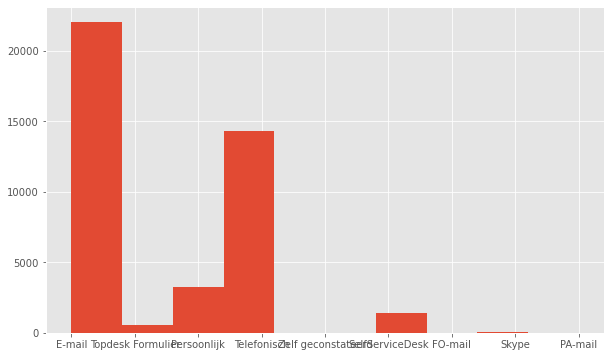

In [166]:
entry_type.hist()

In [167]:
df = df[df["Entry"].str.contains("E-mail", case = False) | df["Entry"].str.contains("Telefonisch", case = False) | df["Entry"].str.contains("Persoonlijk", case = False)| df["Entry"].str.contains("SelfServiceDesk", case = False)]

In [168]:
df.shape

(40911, 12)

We managed to filter out a lot of instances that are not sufficiently represented. Since we have a lot of data we decided to remove them from the data set just for convenience. 

### Remove outliers in the numeric data:

Describe the numeric variables

In [134]:
df[['Target date', 'Date/time of creation', 'Closure Date', 'actual duration']].describe(datetime_is_numeric=True)

,Target date,Date/time of creation,Closure Date,actual duration
count,49028,49028,49028,49028
mean,2017-11-17 08:03:01.771137536,2017-11-13 09:59:27.678123520,2017-11-16 09:51:30.866024192,2 days 23:52:03.187892632
min,2014-12-23 16:24:00,2013-11-22 08:54:34,2015-01-05 07:55:43,-1 days +21:04:19
25%,2016-03-30 11:03:00,2016-03-25 16:03:33.750000128,2016-03-30 03:53:45,0 days 00:00:53
50%,2017-09-22 11:41:00,2017-09-20 12:29:36.500000,2017-09-21 15:01:00,0 days 00:19:59
75%,2019-06-25 18:39:30,2019-06-19 10:40:36.249999872,2019-06-26 10:31:45,0 days 04:36:00.500000
max,2024-07-31 18:00:00,2021-03-13 13:33:57,2021-03-13 14:14:00,1653 days 02:58:58
std,NaN,NaN,NaN,23 days 20:02:58.071309444
